In [52]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import joblib

In [53]:
df = pd.read_csv('../dataset/cleaned_BizPlay_2024_DEC.csv')
df

,Transaction Date,Transaction Time,Transaction Amount,Customer Date of Birth,Customer Gender,Customer Age,Customer Region (City/County/District),Merchant Region (City/County/District),Merchant ID,Sub-Merchant ID,Transaction Processing Agency (VAN),Distance,anomaly,Customer_Encoded,Merchant_Encoded
0,20241201,231124,-38500,70613,0,17,41480,ONLINE,0,0,2,0,1,43,59
1,20241201,225957,-24900,60616,0,18,41271,ONLINE,0,0,2,0,0,25,59
2,20241201,225944,35000,100216,0,15,41550,ONLINE,0,40403,2,0,0,45,59
3,20241201,225937,24900,60616,0,18,41271,ONLINE,0,0,2,0,0,25,59
4,20241201,225935,2500,71026,1,17,41273,41273,1,13424,3,0,0,26,26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
256498,20241231,60704,7700,120111,0,13,41590,41590,1,30364,3,12,0,47,47
256499,20241231,60347,4700,60103,0,19,41131,41131,1,23484,3,0,0,13,13
256500,20241231,60205,3750,100928,1,14,41192,41192,1,30108,3,0,0,19,19
256501,20241231,60158,12600,160405,0,9,41192,41192,1,6636,3,0,0,19,19


In [54]:
# Feature Engineering
df['Log_Transaction_Amount'] = np.log1p(np.abs(df['Transaction Amount']))
df['Transaction_Hour'] = df['Transaction Time'] // 10000

# 4. Feature Selection
selected_features = [
    'Log_Transaction_Amount',
    'Distance',
    'Customer Age',
    'Transaction_Hour',
    'Customer_Encoded',
    'Merchant_Encoded',
    'Sub-Merchant ID'
]

X = df[selected_features]
y = df['anomaly']

In [ ]:
scaler = StandardScaler()
X_scaled = X.copy()
X_scaled[['Log_Transaction_Amount', 'Distance', 'Customer Age', 'Transaction_Hour', 'Customer_Encoded', 'Merchant_Encoded', 'Sub-Merchant ID']] = \
    scaler.fit_transform(X_scaled[['Log_Transaction_Amount', 'Distance', 'Customer Age', 'Transaction_Hour', 'Customer_Encoded', 'Merchant_Encoded', 'Sub-Merchant ID']])


In [56]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

In [57]:
rf_model = RandomForestClassifier(
    n_estimators=100,  # smaller number of trees to avoid memory error
    random_state=42,
    n_jobs=1          # single-threaded
)
rf_model.fit(X_train, y_train)

RandomForestClassifier(n_jobs=1, random_state=42)

In [58]:
y_pred = rf_model.predict(X_test)
y_prob = rf_model.predict_proba(X_test)[:, 1] 

In [59]:
from sklearn.metrics import precision_recall_curve, average_precision_score
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
avg_prec = average_precision_score(y_test, y_prob)

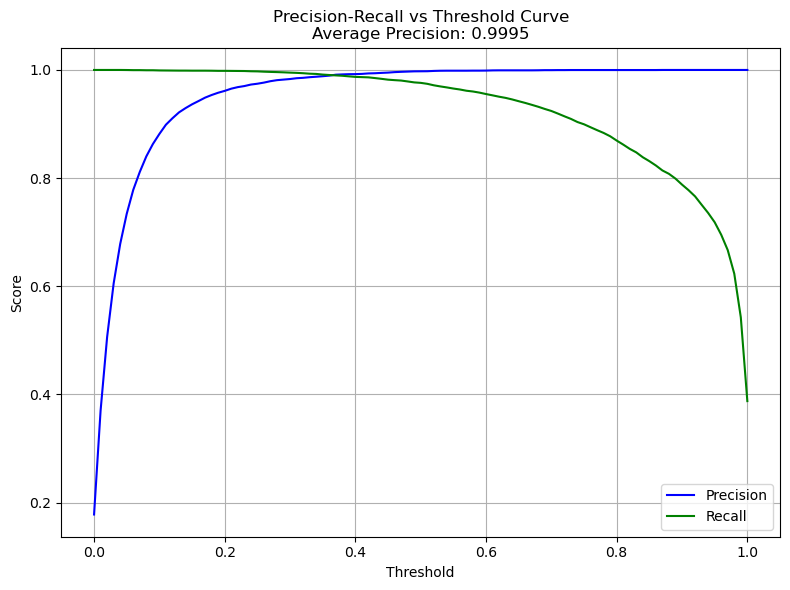

In [60]:
plt.figure(figsize=(8, 6))
plt.plot(thresholds, precision[:-1], label='Precision', color='blue')
plt.plot(thresholds, recall[:-1], label='Recall', color='green')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title(f'Precision-Recall vs Threshold Curve\nAverage Precision: {avg_prec:.4f}')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [61]:
# Optimal threshold based on your chart
optimal_threshold = 0.4  # or try 0.35

y_pred_adjusted = (y_prob > optimal_threshold).astype(int)

print("Adjusted Threshold Evaluation:")
print(classification_report(y_test, y_pred_adjusted))
print(confusion_matrix(y_test, y_pred_adjusted))


Adjusted Threshold Evaluation:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     42162
           1       0.99      0.99      0.99      9139

    accuracy                           1.00     51301
   macro avg       0.99      0.99      0.99     51301
weighted avg       1.00      1.00      1.00     51301

[[42096    66]
 [  121  9018]]


In [62]:
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_prob)
print("\nROC-AUC Score:", roc_auc)

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     42162
           1       1.00      0.97      0.99      9139

    accuracy                           1.00     51301
   macro avg       1.00      0.99      0.99     51301
weighted avg       1.00      1.00      1.00     51301


Confusion Matrix:
[[42141    21]
 [  234  8905]]

ROC-AUC Score: 0.9998815421583241


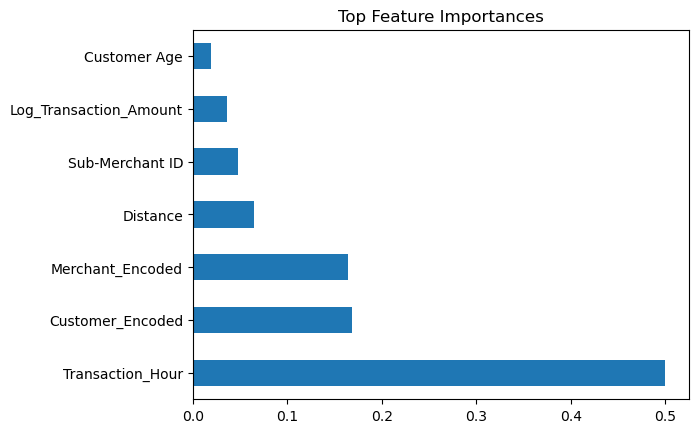

In [63]:
import matplotlib.pyplot as plt
import seaborn as sns

feat_imp = pd.Series(rf_model.feature_importances_, index=X.columns)
feat_imp.nlargest(10).plot(kind='barh')
plt.title("Top Feature Importances")
plt.show()


In [66]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(rf_model, X, y, cv=10, scoring='roc_auc')
print(scores, scores.mean())


[0.99985098 0.99991336 0.99983338 0.99989131 0.99974491 0.99985082
 0.99991433 0.99974284 0.99981072 0.99979627] 0.9998348924006045


In [65]:
joblib.dump(rf_model, 'random_forest_anomaly_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
print("\n✅ Model and scaler saved!")


✅ Model and scaler saved!
